In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'config_score.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'icews14', 'storage_dir': '../data/', 'embedding_config': './embedding_config.json', 'criteria': 'score', 'train_ratio': 0.3, 'hidden_dim': 256, 'max_hops': 4, 'num_neg': 50, 'num_threads': 4, 'decay_factor': 0.2, 'max_fanout': 100, 'beam_width': 20, 'max_epochs': 2, 'batch_size': 4, 'dim_feedforward': 256, 'nhead': 4, 'num_layers': 6, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 5.0, 'positive_deviation': True, 'embedding': 'all', 'test_time': 1, 'num_ckpt': 2, 'scale_loss': True, 'chi2': False, 'lr': 0.0001, 'wandb_project': 'thesis-graph', 'neg_per_pos': 10}


In [2]:
import os, requests, json, pprint

cid  = os.getenv("CONTAINER_ID")          # ← set by Vast.ai inside every container
key  = os.getenv("CONTAINER_API_KEY")     # ← scoped token for this one instance
assert cid and key, "Not running on a Vast.ai container!"

resp = requests.get(
    f"https://console.vast.ai/api/v0/instances/{cid}/",
    headers={"Authorization": f"Bearer {key}",
             "accept": "application/json"},
    timeout=10,
)

info = resp.json()
print("Effective vCPUs:", info['instances']["cpu_cores_effective"])
# print(info['instances'].keys())

Effective vCPUs: 24.0


In [3]:

# Initialize the DataModule and load the data
print("Setting up DataModule...")
dm = PathDataModule(config_path=config_path, batch_size=32)
dm.setup('fit')
print("Data loaded.")


Setting up DataModule...
Setting up data for stage: fit
Setting up data for split: train
Pre-scan enabled for train split. Running full data validation...

--- Pre-scanning and filtering train data points ---
Scanning 630168 edges in train split...


Scanning edges: 100%|██████████| 630168/630168 [00:01<00:00, 493222.02it/s]



Pre-scan Results for train:
  Total edges scanned: 630168
  Valid edges (has pos & neg paths): 293315 (46.5%)
  Missing positive paths: 236845 (37.6%)
  Missing negative paths: 336853 (53.5%)
  Empty negative paths: 0 (0.0%)

⚠️  WARNING: Some edges are missing required path data!
  Filtering train split to keep only 293315 valid edges.
  New edge count for train: 293315
--- Pre-scan complete ---

Use shallow embeddings: True at config ./embedding_config.json
Loading KGE model proxy for train split from ../data/transe_icews14_all_config.json
KGEModelProxy initialized on cuda
Loaded model state from ../data/transe_icews14_all_model.pt to cuda
Device for KGE model: cuda:0
Loaded 293315 edges for train split.
Setting up data for split: valid
Pre-scan not configured for valid split. Skipping data validation.
Use shallow embeddings: True at config ./embedding_config.json
Loading KGE model proxy for valid split from ../data/transe_icews14_all_config.json
KGEModelProxy initialized on cuda
Lo

In [4]:

# --- 2. Data Extraction and Preparation ---
plot_data = []
split = 'valid'  # You can change this to 'valid' or 'test'

print(f"Processing data for '{split}' split...")
edges_df = dm.data[split]
pos_paths = dm.pos_paths[split]
neg_paths = dm.neg_paths[split]


Processing data for 'valid' split...


In [5]:
print(len(pos_paths), len(neg_paths))

81950 64621


In [6]:
edges_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102168 entries, 674830 to 776997
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  102168 non-null  int64
 1   feat_pos_v  102168 non-null  int64
 2   u           102168 non-null  int64
 3   v           102168 non-null  int64
 4   u_type      102168 non-null  int64
 5   v_type      102168 non-null  int64
 6   ts          102168 non-null  int64
 7   split       102168 non-null  int64
 8   label       102168 non-null  int64
 9   edge_type   102168 non-null  int64
 10  v_pos       102168 non-null  int64
dtypes: int64(11)
memory usage: 9.4 MB


In [7]:
edges_df[edges_df['v_pos'] == edges_df['v']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 17028 entries, 674830 to 775287
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  17028 non-null  int64
 1   feat_pos_v  17028 non-null  int64
 2   u           17028 non-null  int64
 3   v           17028 non-null  int64
 4   u_type      17028 non-null  int64
 5   v_type      17028 non-null  int64
 6   ts          17028 non-null  int64
 7   split       17028 non-null  int64
 8   label       17028 non-null  int64
 9   edge_type   17028 non-null  int64
 10  v_pos       17028 non-null  int64
dtypes: int64(11)
memory usage: 1.6 MB


In [8]:
edges_df[edges_df['v_pos'] == edges_df['v']].describe()

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos
count,17028.000000,17028.000000,17028.000000,17028.000000,17028.0,17028.0,17028.000000,17028.0,17028.0,17028.000000,17028.000000
mean,511.397992,511.397992,1073.443740,1073.443740,0.0,0.0,7645.099366,2.0,1.0,139.126028,1073.443740
std,1023.577597,1023.577597,1669.046588,1669.046588,0.0,0.0,195.253569,0.0,0.0,118.093026,1669.046588
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,7296.000000,2.0,1.0,0.000000,0.000000
25%,14.000000,14.000000,72.000000,72.000000,0.0,0.0,7488.000000,2.0,1.0,16.000000,72.000000
50%,93.000000,93.000000,321.000000,321.000000,0.0,0.0,7656.000000,2.0,1.0,228.500000,321.000000
75%,466.250000,466.250000,1203.000000,1203.000000,0.0,0.0,7800.000000,2.0,1.0,246.000000,1203.000000
max,7116.000000,7116.000000,6892.000000,6892.000000,0.0,0.0,7992.000000,2.0,1.0,457.000000,6892.000000


In [9]:
edges_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v   v  u_type  v_type  split  \
u    v_pos edge_type ts                                                        
0    1     0         7536          11          11  11      11      11     11   
                     7560          11          11  11      11      11     11   
                     7608          11          11  11      11      11     11   
                     7680          11          11  11      11      11     11   
                     7728          11          11  11      11      11     11   
...                               ...         ...  ..     ...     ...    ...   
6889 1115  231       7992           1           1   1       1       1      1   
6890 4363  3         7992          11          11  11      11      11     11   
           233       7992           1           1   1       1       1      1   
6891 53    12        7992          11          11  11      11      11     11   
6892 1897  18        7992          11          11  11      11      11     11   

                           label  
u    v_pos edge_type ts           
0    1     0         7536     11  
                     7560     11  
                     7608     11  
                     7680     11  
                     7728     11  
...                          ...  
6889 1115  231       7992      1  
6890 4363  3         7992     11  
           233       7992      1  
6891 53    12        7992     11  
6892 1897  18        7992     11  

[17028 rows x 7 columns]

In [10]:

for eid, row in tqdm(edges_df.iterrows(), total=len(edges_df), desc="Extracting paths"):
    eid_str = str(eid)
    label = row['label']
    u = row['u']
    v = row['v']
    ts = row['ts']
    v_pos = row['v_pos']
    edge_type = row['edge_type']
    edge_meta = {}

    # Process positive path
    if eid_str in pos_paths and pos_paths[eid_str].get('nodes'):
        pos_path_len = len(pos_paths[eid_str]['nodes'])
        edge_meta = {
            'path_length': pos_path_len,
            # 'path_type': 'positive',
            'label': 'true_link' if label == 1 else 'false_link',
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
            
        }
    else:
        edge_meta = {
            'path_length': 0,
            # 'path_type': 'positive',
            'label': 'true_link' if label == 1 else 'false_link',
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
        }

    # # Process negative paths
    # if eid_str in neg_paths:
    #     # for neg_path_interleaved in neg_paths[eid_str]:
    #     #     # As per loader.py, nodes are at even indices
    #     #     neg_path_len = len(neg_path_interleaved[::2])
    #     #     plot_data.append({
    #     #         'path_length': neg_path_len,
    #     #         'path_type': 'negative',
    #     #         'label': 'true_link' if label == 1 else 'false_link'
    #     #     })
    #     edge_meta["num_neg"] = len(neg_paths[eid_str])

    plot_data.append(edge_meta)

Extracting paths: 100%|██████████| 102168/102168 [00:03<00:00, 30298.55it/s]


In [11]:

plot_df = pd.DataFrame(plot_data)
print("Data prepared for plotting.")


Data prepared for plotting.


In [12]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102168 entries, 0 to 102167
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   path_length  102168 non-null  int64 
 1   label        102168 non-null  object
 2   u            102168 non-null  int64 
 3   v            102168 non-null  int64 
 4   ts           102168 non-null  int64 
 5   edge_type    102168 non-null  int64 
 6   v_pos        102168 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 5.5+ MB


In [13]:
edges_fp = os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_edges.csv")
df = pd.read_csv(edges_fp, index_col='edge_id')            
split_map = {str(idx): row['split'] for idx, row in df.iterrows()}

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865450 entries, 0 to 865449
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  865450 non-null  int64
 1   feat_pos_v  865450 non-null  int64
 2   u           865450 non-null  int64
 3   v           865450 non-null  int64
 4   u_type      865450 non-null  int64
 5   v_type      865450 non-null  int64
 6   ts          865450 non-null  int64
 7   split       865450 non-null  int64
 8   label       865450 non-null  int64
 9   edge_type   865450 non-null  int64
 10  v_pos       865450 non-null  int64
dtypes: int64(11)
memory usage: 79.2 MB


In [15]:
df[(df['v_pos'] == df['v']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14742 entries, 776998 to 863679
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  14742 non-null  int64
 1   feat_pos_v  14742 non-null  int64
 2   u           14742 non-null  int64
 3   v           14742 non-null  int64
 4   u_type      14742 non-null  int64
 5   v_type      14742 non-null  int64
 6   ts          14742 non-null  int64
 7   split       14742 non-null  int64
 8   label       14742 non-null  int64
 9   edge_type   14742 non-null  int64
 10  v_pos       14742 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


In [16]:
df[(df['label'] == 1) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14742 entries, 776998 to 863679
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  14742 non-null  int64
 1   feat_pos_v  14742 non-null  int64
 2   u           14742 non-null  int64
 3   v           14742 non-null  int64
 4   u_type      14742 non-null  int64
 5   v_type      14742 non-null  int64
 6   ts          14742 non-null  int64
 7   split       14742 non-null  int64
 8   label       14742 non-null  int64
 9   edge_type   14742 non-null  int64
 10  v_pos       14742 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


In [17]:
df[(df['v_pos'] == df['u']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  0 non-null      int64
 1   feat_pos_v  0 non-null      int64
 2   u           0 non-null      int64
 3   v           0 non-null      int64
 4   u_type      0 non-null      int64
 5   v_type      0 non-null      int64
 6   ts          0 non-null      int64
 7   split       0 non-null      int64
 8   label       0 non-null      int64
 9   edge_type   0 non-null      int64
 10  v_pos       0 non-null      int64
dtypes: int64(11)
memory usage: 0.0 bytes


In [18]:
df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v   v  u_type  v_type  split  \
u    v_pos edge_type ts                                                        
0    1     0         0              1           1   1       1       1      1   
                     552            1           1   1       1       1      1   
                     864            1           1   1       1       1      1   
                     1008           1           1   1       1       1      1   
                     1080           1           1   1       1       1      1   
...                               ...         ...  ..     ...     ...    ...   
7123 644   234       8712           1           1   1       1       1      1   
7124 156   9         8712          11          11  11      11      11     11   
7125 1030  239       8736           1           1   1       1       1      1   
7126 85    21        8736          11          11  11      11      11     11   
7127 94    9         8736          11          11  11      11      11     11   

                           label  
u    v_pos edge_type ts           
0    1     0         0         1  
                     552       1  
                     864       1  
                     1008      1  
                     1080      1  
...                          ...  
7123 644   234       8712      1  
7124 156   9         8712     11  
7125 1030  239       8736      1  
7126 85    21        8736     11  
7127 94    9         8736     11  

[181460 rows x 7 columns]

In [19]:
df[df["split"] == 2].groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v   v  u_type  v_type  split  \
u    v_pos edge_type ts                                                        
0    1     0         7536          11          11  11      11      11     11   
                     7560          11          11  11      11      11     11   
                     7608          11          11  11      11      11     11   
                     7680          11          11  11      11      11     11   
                     7728          11          11  11      11      11     11   
...                               ...         ...  ..     ...     ...    ...   
6889 1115  231       7992           1           1   1       1       1      1   
6890 4363  3         7992          11          11  11      11      11     11   
           233       7992           1           1   1       1       1      1   
6891 53    12        7992          11          11  11      11      11     11   
6892 1897  18        7992          11          11  11      11      11     11   

                           label  
u    v_pos edge_type ts           
0    1     0         7536     11  
                     7560     11  
                     7608     11  
                     7680     11  
                     7728     11  
...                          ...  
6889 1115  231       7992      1  
6890 4363  3         7992     11  
           233       7992      1  
6891 53    12        7992     11  
6892 1897  18        7992     11  

[17028 rows x 7 columns]

In [20]:
# len(split_map.keys())

In [21]:
# list(split_map.values())[-1]

In [22]:
# split_code = {'pre': 0, 'train': 1, 'valid': 2, 'test': 3}

# print(f"Setting up data for split: {split}")

# pos_paths = {}
# with open(os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_paths.txt")) as f:
#     n_str = f.readline()
#     n = int(n_str) if n_str and n_str.strip() else 0
#     for _ in tqdm(range(n)):
#         eid = f.readline().strip()
#         if not eid:
#             break
#         hops = int(f.readline())
#         nodes = [int(u) for u in f.readline().split()]
#         node_types = [int(t) for t in f.readline().split()]
#         edge_types_str = f.readline().strip().split()
#         edge_types = [int(et) for et in edge_types_str if et]
        
#         edge_timestamps_str = f.readline().strip().split()
#         edge_timestamps = [int(ts) for ts in edge_timestamps_str if ts]

#         if split_map.get(eid) == split_code[split]:
#             pos_paths[eid] = {
#                 "hops": hops,
#                 "nodes": nodes,
#                 "node_types": node_types,
#                 "edge_types": edge_types,
#                 "edge_timestamps": edge_timestamps
#             }


In [23]:
# len(pos_paths.keys())

In [24]:
plot_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,true_link,44,211,7296,3,211
1,2,true_link,567,13,7296,70,13
2,2,true_link,27,44,7296,9,44
3,2,true_link,53,44,7296,32,44
4,2,true_link,590,8,7296,41,8
...,...,...,...,...,...,...,...
102163,4,false_link,88,2584,7992,13,8
102164,5,false_link,88,5474,7992,13,8
102165,3,false_link,88,3669,7992,13,8
102166,4,false_link,88,5911,7992,13,8


In [25]:
pos_df = plot_df[plot_df["path_length"] > 0].copy()
pos_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,true_link,44,211,7296,3,211
1,2,true_link,567,13,7296,70,13
2,2,true_link,27,44,7296,9,44
3,2,true_link,53,44,7296,32,44
4,2,true_link,590,8,7296,41,8
...,...,...,...,...,...,...,...
102163,4,false_link,88,2584,7992,13,8
102164,5,false_link,88,5474,7992,13,8
102165,3,false_link,88,3669,7992,13,8
102166,4,false_link,88,5911,7992,13,8


In [26]:
temp = pos_df[pos_df["label"] == "true_link"].groupby("path_length").count()
temp

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,12433,12433,12433,12433,12433,12433
3,3130,3130,3130,3130,3130,3130
4,559,559,559,559,559,559
5,128,128,128,128,128,128


In [27]:
temp / temp.sum() * 100

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,76.510769,76.510769,76.510769,76.510769,76.510769,76.510769
3,19.261538,19.261538,19.261538,19.261538,19.261538,19.261538
4,3.440000,3.440000,3.440000,3.440000,3.440000,3.440000
5,0.787692,0.787692,0.787692,0.787692,0.787692,0.787692


In [28]:
pos_df[pos_df["label"] == "false_link"].groupby("path_length").count()

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
3,13430,13430,13430,13430,13430,13430
4,28780,28780,28780,28780,28780,28780
5,23490,23490,23490,23490,23490,23490


In [29]:
plot_df[plot_df["path_length"] < 2]

,path_length,label,u,v,ts,edge_type,v_pos
19,0,true_link,404,6616,7296,1,6616
64,0,true_link,6617,6616,7296,9,6616
73,0,true_link,6617,6616,7296,46,6616
94,0,true_link,1074,974,7296,9,974
98,0,true_link,6618,6619,7296,32,6619
...,...,...,...,...,...,...,...
102075,0,false_link,6892,2407,7992,18,1897
102076,0,false_link,6892,1161,7992,18,1897
102077,0,false_link,6892,3713,7992,18,1897
102085,0,false_link,786,5475,7992,0,4003


In [30]:
def calculate_metrics(group):
    """
    Calculates MRR and Hits@K for a group of predictions for a single query.
    The group contains one 'true_link' and multiple 'false_link' rows.
    A lower 'path_length' is considered a better score.
    """
    true_link = group[group['label'] == 'true_link']
    if true_link.empty:
        return pd.Series({
            'rank': 0, 'mrr': 1, 'hits@1': 1, 'hits@3': 1, 'hits@10': 1
        })

    # Lower path_length is better.
    true_path_length = true_link['path_length'].min()
    
    # Rank is 1 + number of negative samples with a better (smaller) or equal path length.
    # We use '<=' because if scores are tied, the true link does not get the best rank.
    rank = 1 + group[(group['label'] == 'false_link') & (group['path_length'] < true_path_length)].shape[0]
    
    mrr = 1.0 / rank
    hits_at_1 = 1.0 if rank <= 1 else 0.0
    hits_at_3 = 1.0 if rank <= 3 else 0.0
    hits_at_10 = 1.0 if rank <= 10 else 0.0
    
    return pd.Series({
        'rank': rank,
        'mrr': mrr,
        'hits@1': hits_at_1,
        'hits@3': hits_at_3,
        'hits@10': hits_at_10
    })


In [31]:

# Group by the query identifiers.
# This assumes that for each (u, v, ts, edge_type) combination that forms a true link,
# there are corresponding negative samples that share these identifiers in some way
# that allows grouping. If negative samples have different u or v, the grouping key needs adjustment.
# Based on the request, we group by ('u', 'v', 'ts', 'edge_type').
grouped = plot_df.groupby(['u', "v_pos", "edge_type", "ts"])


In [32]:

# Apply the function to each group and get the results.
metrics_df = grouped.apply(calculate_metrics, include_groups=False).reset_index()


In [33]:

print("Metrics per query:")
metrics_df


Metrics per query:


,u,v_pos,edge_type,ts,rank,mrr,hits@1,hits@3,hits@10
0,0,1,0,7536,3.0,0.333333,0.0,1.0,1.0
1,0,1,0,7560,3.0,0.333333,0.0,1.0,1.0
2,0,1,0,7608,3.0,0.333333,0.0,1.0,1.0
3,0,1,0,7680,3.0,0.333333,0.0,1.0,1.0
4,0,1,0,7728,3.0,0.333333,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
17023,6889,1115,231,7992,1.0,1.000000,1.0,1.0,1.0
17024,6890,4363,3,7992,1.0,1.000000,1.0,1.0,1.0
17025,6890,4363,233,7992,1.0,1.000000,1.0,1.0,1.0
17026,6891,53,12,7992,1.0,1.000000,1.0,1.0,1.0


In [34]:

print("\nAverage metrics across all queries:")
metrics_df[['mrr', 'hits@1', 'hits@3', 'hits@10']].mean() * 100



Average metrics across all queries:


mrr        73.606475
hits@1     60.165610
hits@3     84.096782
hits@10    99.829692
dtype: float64

<Axes: ylabel='Frequency'>

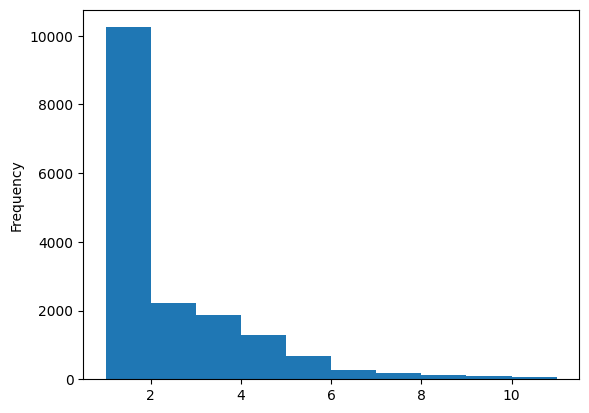

In [35]:
metrics_df['rank'].plot.hist(bins=10)

In [36]:
metrics_df.groupby('rank').count()

,u,v_pos,edge_type,ts,mrr,hits@1,hits@3,hits@10
rank,,,,,,,,
1.0,10245,10245,10245,10245,10245,10245,10245,10245
2.0,2212,2212,2212,2212,2212,2212,2212,2212
3.0,1863,1863,1863,1863,1863,1863,1863,1863
4.0,1285,1285,1285,1285,1285,1285,1285,1285
5.0,681,681,681,681,681,681,681,681
6.0,280,280,280,280,280,280,280,280
7.0,179,179,179,179,179,179,179,179
8.0,123,123,123,123,123,123,123,123
9.0,82,82,82,82,82,82,82,82


In [3]:
results = None
with open("../data/transe/icews14/thesis-graph/6anz0hpb/train_val_0_raw.json") as f:
    results = json.load(f)

In [4]:
len(results)

68947

In [5]:
len([result for result in results if result['label'] == 0])

65551

In [6]:
len([result for result in results if result['label'] == 1])

3396

In [7]:
results[0]

{'u': 47,
 'v': 1313,
 'v_pos': 1313,
 'ts': 7296,
 'edge_type': 81,
 'label': 1,
 'loss': 0.8813708424568176,
 'score': 0.7859311699867249,
 'length': 2}

In [8]:
result_df = pd.DataFrame(results)
result_df

,u,v,v_pos,ts,edge_type,label,loss,score,length
0,47,1313,1313,7296,81,1,0.881371,0.785931,2
1,2542,5993,5993,7296,32,1,0.420252,0.771530,2
2,1601,2449,2449,7296,32,1,2.152298,0.759314,2
3,676,5230,5230,7296,33,1,-1.602039,0.776101,2
4,607,87,87,7296,1,1,0.881394,0.786920,2
...,...,...,...,...,...,...,...,...,...
68942,88,2584,8,7992,13,0,-0.699142,0.968495,3
68943,88,5474,8,7992,13,0,0.935723,0.940803,4
68944,88,3669,8,7992,13,0,-1.776305,0.784253,2
68945,88,5911,8,7992,13,0,-0.285741,0.994262,3


In [9]:
result_df.describe()

,u,v,v_pos,ts,edge_type,label,loss,score,length
count,68947.000000,68947.000000,68947.000000,68947.000000,68947.000000,68947.000000,68947.000000,68947.000000,68947.000000
mean,902.186984,3188.362974,953.521241,7649.211133,29.971949,0.049255,0.148186,0.924907,3.021364
std,1362.565803,1965.579974,1550.457902,194.695040,44.473963,0.216402,1.019594,0.081760,0.725918
min,0.000000,0.000000,0.000000,7296.000000,0.000000,0.000000,-2.204543,0.719052,2.000000
25%,72.000000,1442.000000,53.000000,7488.000000,9.000000,0.000000,-0.601021,0.827478,2.000000
50%,324.000000,3145.000000,240.000000,7656.000000,16.000000,0.000000,0.247264,0.961570,3.000000
75%,1044.000000,4890.000000,1034.000000,7824.000000,32.000000,0.000000,0.881296,0.985450,4.000000
max,6882.000000,6886.000000,6890.000000,7992.000000,457.000000,1.000000,2.204317,1.042331,4.000000


In [10]:
result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

v  label  loss  score  length
u    v_pos edge_type ts                                 
0    1     0         7536  8      8     8      8       8
                     7560  8      8     8      8       8
                     7608  8      8     8      8       8
                     7680  8      8     8      8       8
                     7728  8      8     8      8       8
...                       ..    ...   ...    ...     ...
6803 364   100       7992  4      4     4      4       4
     3581  9         7800  5      5     5      5       5
6843 6418  32        7920  2      2     2      2       2
6873 359   9         7968  9      9     9      9       9
6882 433   103       7968  7      7     7      7       7

[9999 rows x 5 columns]

In [11]:
test_df = pd.merge(df[df["split"] == 2], result_df, on=["u", "v_pos", "edge_type", "ts", "v", "label"])
test_df

NameError: name 'df' is not defined

In [46]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u    v_pos edge_type ts                                                       
0    1     0         7536           8           8  8       8       8      8   
                     7560           8           8  8       8       8      8   
                     7608           8           8  8       8       8      8   
                     7680           8           8  8       8       8      8   
                     7728           8           8  8       8       8      8   
...                               ...         ... ..     ...     ...    ...   
6803 364   100       7992           4           4  4       4       4      4   
     3581  9         7800           5           5  5       5       5      5   
6843 6418  32        7920           2           2  2       2       2      2   
6873 359   9         7968           9           9  9       9       9      9   
6882 433   103       7968           7           7  7       7       7      7   

                           label  loss  score  length  
u    v_pos edge_type ts                                
0    1     0         7536      8     8      8       8  
                     7560      8     8      8       8  
                     7608      8     8      8       8  
                     7680      8     8      8       8  
                     7728      8     8      8       8  
...                          ...   ...    ...     ...  
6803 364   100       7992      4     4      4       4  
     3581  9         7800      5     5      5       5  
6843 6418  32        7920      2     2      2       2  
6873 359   9         7968      9     9      9       9  
6882 433   103       7968      7     7      7       7  

[9999 rows x 10 columns]

In [47]:
test = result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()
test[test["v"] > 1]

v  label  loss  score  length
u    v_pos edge_type ts                                 
0    1     0         7536  8      8     8      8       8
                     7560  8      8     8      8       8
                     7608  8      8     8      8       8
                     7680  8      8     8      8       8
                     7728  8      8     8      8       8
...                       ..    ...   ...    ...     ...
6803 364   100       7992  4      4     4      4       4
     3581  9         7800  5      5     5      5       5
6843 6418  32        7920  2      2     2      2       2
6873 359   9         7968  9      9     9      9       9
6882 433   103       7968  7      7     7      7       7

[8241 rows x 5 columns]

In [12]:
from evaluation import evaluate
from collections import defaultdict

In [13]:
# edge_groups = defaultdict(lambda: {'pos_score': None, 'neg_scores': []})
# for item in results:
#     # Use v_pos as the target node for grouping, which is the true target for all edges
#     v_for_grouping = item.get('v_pos', item['v'])
#     key = (item['u'], item.get('edge_type'), v_for_grouping, item['ts'])
#     score = item['score']  # Now using the adjusted score
#     length = item['length']
    
#     if item['label'] == 1:
#         edge_groups[key]['pos_score'] = (score, length)
#     else:
#         edge_groups[key]['neg_scores'].append((score, length))

In [14]:
# final = evaluate(edge_groups, verbose=False)
final = evaluate(results, verbose=False)
final

({'rank': 0.37683768376837684,
  'mrr': 0.9908531329323408,
  'hits@1': 0.9862986298629863,
  'hits@3': 0.9940994099409941,
  'hits@10': 1.0},
          u  v_pos  edge_type    ts  rank  mrr  hits@1  hits@3  hits@10
 0        0      1          0  7536   0.0  1.0     1.0     1.0      1.0
 1        0      1          0  7560   0.0  1.0     1.0     1.0      1.0
 2        0      1          0  7608   0.0  1.0     1.0     1.0      1.0
 3        0      1          0  7680   0.0  1.0     1.0     1.0      1.0
 4        0      1          0  7728   0.0  1.0     1.0     1.0      1.0
 ...    ...    ...        ...   ...   ...  ...     ...     ...      ...
 9994  6803    364        100  7992   0.0  1.0     1.0     1.0      1.0
 9995  6803   3581          9  7800   0.0  1.0     1.0     1.0      1.0
 9996  6843   6418         32  7920   0.0  1.0     1.0     1.0      1.0
 9997  6873    359          9  7968   0.0  1.0     1.0     1.0      1.0
 9998  6882    433        103  7968   1.0  1.0     1.0     1.0   

In [51]:
test_df

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,loss,score,length
0,11,1092,47,1313,0,0,7296,2,1,81,1313,0.881371,0.785931,2
1,1239,2946,2542,5993,0,0,7296,2,1,32,5993,0.420252,0.771530,2
2,648,1548,1601,2449,0,0,7296,2,1,32,2449,2.152298,0.759314,2
3,186,2601,676,5230,0,0,7296,2,1,33,5230,-1.602039,0.776101,2
4,23,121,607,87,0,0,7296,2,1,1,87,0.881394,0.786920,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68942,44,561,88,2584,0,0,7992,2,0,13,8,-0.699142,0.968495,3
68943,44,4858,88,5474,0,0,7992,2,0,13,8,0.935723,0.940803,4
68944,44,5108,88,3669,0,0,7992,2,0,13,8,-1.776305,0.784253,2
68945,44,2093,88,5911,0,0,7992,2,0,13,8,-0.285741,0.994262,3


In [52]:
def process(group):
    return group.loc[group["label"] == 0, "length"].min()

In [53]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).apply(process)

/tmp/ipykernel_9766/1782117757.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df.groupby(["u", "v_pos", "edge_type", "ts"]).apply(process)


u     v_pos  edge_type  ts  
0     1      0          7536    2.0
                        7560    2.0
                        7608    2.0
                        7680    2.0
                        7728    2.0
                               ... 
6803  364    100        7992    4.0
      3581   9          7800    3.0
6843  6418   32         7920    4.0
6873  359    9          7968    3.0
6882  433    103        7968    3.0
Length: 9999, dtype: float64

In [54]:
check = pd.merge(result_df, plot_df, on=["u", "v", "v_pos", "ts", "edge_type"])
check

,u,v,v_pos,ts,edge_type,label_x,loss,score,length,path_length,label_y
0,47,1313,1313,7296,81,1,0.881371,0.785931,2,3,true_link
1,2542,5993,5993,7296,32,1,0.420252,0.771530,2,3,true_link
2,1601,2449,2449,7296,32,1,2.152298,0.759314,2,3,true_link
3,676,5230,5230,7296,33,1,-1.602039,0.776101,2,3,true_link
4,607,87,87,7296,1,1,0.881394,0.786920,2,3,true_link
...,...,...,...,...,...,...,...,...,...,...,...
68942,88,2584,8,7992,13,0,-0.699142,0.968495,3,4,false_link
68943,88,5474,8,7992,13,0,0.935723,0.940803,4,5,false_link
68944,88,3669,8,7992,13,0,-1.776305,0.784253,2,3,false_link
68945,88,5911,8,7992,13,0,-0.285741,0.994262,3,4,false_link


In [55]:
(check['length'] - check['path_length'] + 1).max()

np.int64(0)